In [1]:
%cd ..

/home/alberto/Work/incomplete_multiview_clustering


/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Tutorial: Block-wise missing data generation

## Prerequisites

We will need the following libraries installed: matplotlib

## Step 1: Import required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imml.ampute import Amputer
from imml.utils import DatasetUtils
from imml.impute import get_observed_mod_indicator

In [3]:
from tueplots import axes, bundles
plt.rcParams.update(**bundles.icml2022(), **axes.lines())
for key in ["axes.labelsize", "axes.titlesize", "font.size", "legend.fontsize", "xtick.labelsize", "ytick.labelsize"]:
    plt.rcParams[key] += 6
# plt.rcParams.update({'text.usetex': False, "svg.fonttype": 'none'})

## Step 2: Load the dataset

Let's create a random multi-view dataset with 1000 samples and 5 views.

In [4]:
RANDOM_STATE = 7
n_views = 4
n_samples = 10
Xs = [pd.DataFrame(np.random.default_rng(RANDOM_STATE).random((n_samples, 10))) for i in range(n_views)]

## Step 3: Apply missing data mechanism (Amputation)

Using Amputer, we randomly introduce missing data to simulate a scenario where some modalities are missing. Here, 30% of the samples will be incomplete.

In [5]:
mechanism = "mem"
transformed_Xs = Amputer(mechanism=mechanism, p=0.8, random_state=RANDOM_STATE).fit_transform(Xs)

We can visualize which modalities are missing using a binary color map, where black means observed and white means empty (missing).

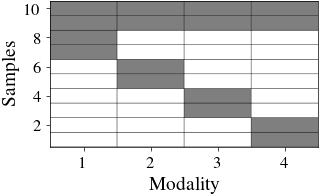

In [6]:
xlabel,ylabel = "Modality", "Samples"
observed_view_indicator = get_observed_mod_indicator(transformed_Xs).sort_values(list(range(len(transformed_Xs))))
observed_view_indicator.columns = observed_view_indicator.columns + 1
plt.pcolor(observed_view_indicator, cmap="binary", edgecolors="black", vmin=0., vmax=2.)
plt.xticks(np.arange(0.5, len(observed_view_indicator.columns), 1), observed_view_indicator.columns)
plt.yticks(np.arange(1.5, len(observed_view_indicator), 2), np.arange(2, len(observed_view_indicator)+2, 2))
_ = plt.xlabel(xlabel), plt.ylabel(ylabel)

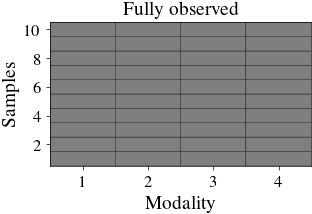

In [7]:
_,ax = plt.subplots(1,1, figsize= (3.18,2.2))
# plt.figure(figsize= (3,2.5))
transformed_Xs = Amputer(mechanism=mechanism, p=0., random_state=RANDOM_STATE).fit_transform(Xs)
observed_view_indicator = get_observed_mod_indicator(transformed_Xs).sort_values(list(range(len(transformed_Xs))))
observed_view_indicator.columns = observed_view_indicator.columns + 1
ax.pcolor(observed_view_indicator, cmap="binary", edgecolors="black", vmin=0., vmax=2.)
ax.set_title("Fully observed")
ax.set_xticks(np.arange(0.5, len(observed_view_indicator.columns), 1), observed_view_indicator.columns)
ax.set_yticks(np.arange(1.5, len(observed_view_indicator), 2), np.arange(2, len(observed_view_indicator)+2, 2))
ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)

plt.savefig("paper_figures/amputation_fully.pdf")
plt.savefig("paper_figures/amputation_fully.svg")

## Step 4: Visualize different amputation mechanisms 

We will show the four different amputation mechanisms: UM, PM, MCAR and MNAR. 

In [8]:
mechanism_dict = {"mem": "Mutually exclusive missing",
                  "pm": "Partial missing",
                  "mcar": "Missing completely at random",
                  "mnar": "Missing not at random",
                  }

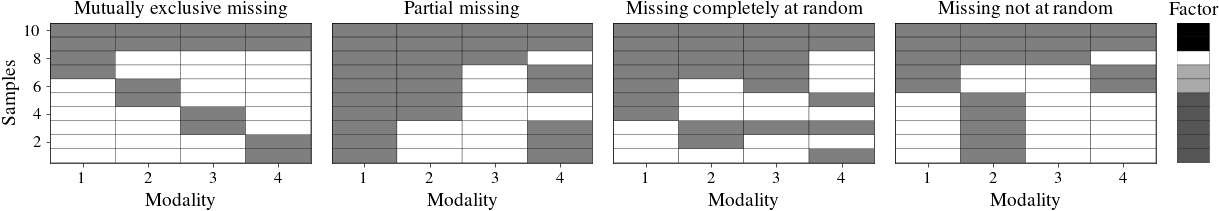

In [9]:
samples_dict = {}
fig,axs = plt.subplots(1,5, figsize= (12.5,2.5), gridspec_kw={'width_ratios': [4, 4, 4, 4, 0.5]})
for idx, (ax, mechanism) in enumerate(zip(axs, list(mechanism_dict.keys()))):
    transformed_Xs = Amputer(mechanism=mechanism, p=0.8, random_state=RANDOM_STATE).fit_transform(Xs)
    observed_view_indicator = get_observed_mod_indicator(transformed_Xs).sort_values(list(range(len(transformed_Xs))))
    observed_view_indicator.columns = observed_view_indicator.columns + 1
    ax.pcolor(observed_view_indicator, cmap="binary", edgecolors="black", vmin=0., vmax=2.)
    ax.set_title(mechanism_dict[mechanism])
    ax.set_xticks(np.arange(0.5, len(observed_view_indicator.columns), 1), observed_view_indicator.columns)
    ax.set_yticks(np.arange(1.5, len(observed_view_indicator), 2), np.arange(2, len(observed_view_indicator)+2, 2))
    ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
    if idx != 0:
        ax.get_yaxis().set_visible(False)
    samples_dict[mechanism_dict[mechanism]] = DatasetUtils.get_summary(Xs=transformed_Xs)

ax = axs[-1]
ax.pcolor(pd.DataFrame([1, 1, 1, 1, 1, 2, 2, 3, 0, 0]), cmap="gray", edgecolors="black")
ax.set_title("Factor")
ax.axis("off")

plt.tight_layout()

plt.savefig("paper_figures/amputation.pdf")
plt.savefig("paper_figures/amputation.svg")

As shown in the below table, all samples have the same number of complete and incomplete samples. However, the amount of observed samples in each modality varies depending on the chosen missing pattern.

In [10]:
pd.DataFrame.from_dict(samples_dict, orient= "index")

,Complete samples,Incomplete samples,Observed samples per modality,Missing samples per modality,% Observed samples per modality,% Missing samples per modality
Mutually exclusive missing,2,8,"[4, 4, 4, 4]","[6, 6, 6, 6]","[40, 40, 40, 40]","[60, 60, 60, 60]"
Partial missing,2,8,"[10, 7, 3, 7]","[0, 3, 7, 3]","[100, 70, 30, 70]","[0, 30, 70, 30]"
Missing completely at random,2,8,"[7, 6, 6, 5]","[3, 4, 4, 5]","[70, 60, 60, 50]","[30, 40, 40, 50]"
Missing not at random,2,8,"[5, 8, 3, 4]","[5, 2, 7, 6]","[50, 80, 30, 40]","[50, 20, 70, 60]"


In [11]:
print(pd.DataFrame.from_dict(samples_dict, orient= "index").drop(
    columns=["% Observed samples per modality", "Missing samples per modality", "% Missing samples per modality"]).to_latex())

\begin{tabular}{lrrl}
\toprule
 & Complete samples & Incomplete samples & Observed samples per modality \\
\midrule
Mutually exclusive missing & 2 & 8 & [4, 4, 4, 4] \\
Partial missing & 2 & 8 & [10, 7, 3, 7] \\
Missing completely at random & 2 & 8 & [7, 6, 6, 5] \\
Missing not at random & 2 & 8 & [5, 8, 3, 4] \\
\bottomrule
\end{tabular}



,Complete samples,Incomplete samples,Observed samples per modality,Missing samples per modality,% Observed samples per modality,% Missing samples per modality
mem,90,10,"[92, 92, 92, 92, 92]","[8, 8, 8, 8, 8]","[92, 92, 92, 92, 92]","[8, 8, 8, 8, 8]"
pm,90,10,"[100, 98, 93, 100, 92]","[0, 2, 7, 0, 8]","[100, 98, 93, 100, 92]","[0, 2, 7, 0, 8]"
mcar,90,10,"[94, 93, 95, 95, 94]","[6, 7, 5, 5, 6]","[94, 93, 95, 95, 94]","[6, 7, 5, 5, 6]"
mnar,90,10,"[97, 95, 94, 92, 95]","[3, 5, 6, 8, 5]","[97, 95, 94, 92, 95]","[3, 5, 6, 8, 5]"


,Complete samples,Incomplete samples,Observed samples per modality,Missing samples per modality,% Observed samples per modality,% Missing samples per modality
mem,80,20,"[84, 84, 84, 84, 84]","[16, 16, 16, 16, 16]","[84, 84, 84, 84, 84]","[16, 16, 16, 16, 16]"
pm,80,20,"[100, 94, 85, 100, 87]","[0, 6, 15, 0, 13]","[100, 94, 85, 100, 87]","[0, 6, 15, 0, 13]"
mcar,80,20,"[86, 90, 88, 89, 87]","[14, 10, 12, 11, 13]","[86, 90, 88, 89, 87]","[14, 10, 12, 11, 13]"
mnar,80,20,"[97, 88, 92, 87, 90]","[3, 12, 8, 13, 10]","[97, 88, 92, 87, 90]","[3, 12, 8, 13, 10]"


,Complete samples,Incomplete samples,Observed samples per modality,Missing samples per modality,% Observed samples per modality,% Missing samples per modality
mem,70,30,"[76, 76, 76, 76, 76]","[24, 24, 24, 24, 24]","[76, 76, 76, 76, 76]","[24, 24, 24, 24, 24]"
pm,70,30,"[100, 90, 78, 100, 83]","[0, 10, 22, 0, 17]","[100, 90, 78, 100, 83]","[0, 10, 22, 0, 17]"
mcar,70,30,"[81, 85, 83, 85, 82]","[19, 15, 17, 15, 18]","[81, 85, 83, 85, 82]","[19, 15, 17, 15, 18]"
mnar,70,30,"[93, 86, 88, 79, 84]","[7, 14, 12, 21, 16]","[93, 86, 88, 79, 84]","[7, 14, 12, 21, 16]"


,Complete samples,Incomplete samples,Observed samples per modality,Missing samples per modality,% Observed samples per modality,% Missing samples per modality
mem,60,40,"[68, 68, 68, 68, 68]","[32, 32, 32, 32, 32]","[68, 68, 68, 68, 68]","[32, 32, 32, 32, 32]"
pm,60,40,"[100, 85, 72, 100, 79]","[0, 15, 28, 0, 21]","[100, 85, 72, 100, 79]","[0, 15, 28, 0, 21]"
mcar,60,40,"[76, 80, 79, 77, 78]","[24, 20, 21, 23, 22]","[76, 80, 79, 77, 78]","[24, 20, 21, 23, 22]"
mnar,60,40,"[92, 78, 84, 74, 78]","[8, 22, 16, 26, 22]","[92, 78, 84, 74, 78]","[8, 22, 16, 26, 22]"


,Complete samples,Incomplete samples,Observed samples per modality,Missing samples per modality,% Observed samples per modality,% Missing samples per modality
mem,50,50,"[60, 60, 60, 60, 60]","[40, 40, 40, 40, 40]","[60, 60, 60, 60, 60]","[40, 40, 40, 40, 40]"
pm,50,50,"[100, 78, 69, 100, 72]","[0, 22, 31, 0, 28]","[100, 78, 69, 100, 72]","[0, 22, 31, 0, 28]"
mcar,50,50,"[72, 77, 76, 73, 70]","[28, 23, 24, 27, 30]","[72, 77, 76, 73, 70]","[28, 23, 24, 27, 30]"
mnar,50,50,"[88, 75, 79, 66, 72]","[12, 25, 21, 34, 28]","[88, 75, 79, 66, 72]","[12, 25, 21, 34, 28]"


,Complete samples,Incomplete samples,Observed samples per modality,Missing samples per modality,% Observed samples per modality,% Missing samples per modality
mem,40,60,"[52, 52, 52, 52, 52]","[48, 48, 48, 48, 48]","[52, 52, 52, 52, 52]","[48, 48, 48, 48, 48]"
pm,40,60,"[100, 73, 63, 100, 69]","[0, 27, 37, 0, 31]","[100, 73, 63, 100, 69]","[0, 27, 37, 0, 31]"
mcar,40,60,"[67, 72, 71, 69, 66]","[33, 28, 29, 31, 34]","[67, 72, 71, 69, 66]","[33, 28, 29, 31, 34]"
mnar,40,60,"[86, 68, 76, 62, 64]","[14, 32, 24, 38, 36]","[86, 68, 76, 62, 64]","[14, 32, 24, 38, 36]"


,Complete samples,Incomplete samples,Observed samples per modality,Missing samples per modality,% Observed samples per modality,% Missing samples per modality
mem,30,70,"[44, 44, 44, 44, 44]","[56, 56, 56, 56, 56]","[44, 44, 44, 44, 44]","[56, 56, 56, 56, 56]"
pm,30,70,"[100, 67, 59, 100, 63]","[0, 33, 41, 0, 37]","[100, 67, 59, 100, 63]","[0, 33, 41, 0, 37]"
mcar,30,70,"[64, 65, 65, 65, 61]","[36, 35, 35, 35, 39]","[64, 65, 65, 65, 61]","[36, 35, 35, 35, 39]"
mnar,30,70,"[84, 65, 73, 54, 60]","[16, 35, 27, 46, 40]","[84, 65, 73, 54, 60]","[16, 35, 27, 46, 40]"


,Complete samples,Incomplete samples,Observed samples per modality,Missing samples per modality,% Observed samples per modality,% Missing samples per modality
mem,20,80,"[36, 36, 36, 36, 36]","[64, 64, 64, 64, 64]","[36, 36, 36, 36, 36]","[64, 64, 64, 64, 64]"
pm,20,80,"[100, 61, 54, 100, 61]","[0, 39, 46, 0, 39]","[100, 61, 54, 100, 61]","[0, 39, 46, 0, 39]"
mcar,20,80,"[61, 61, 61, 62, 53]","[39, 39, 39, 38, 47]","[61, 61, 61, 62, 53]","[39, 39, 39, 38, 47]"
mnar,20,80,"[82, 59, 68, 47, 55]","[18, 41, 32, 53, 45]","[82, 59, 68, 47, 55]","[18, 41, 32, 53, 45]"


,Complete samples,Incomplete samples,Observed samples per modality,Missing samples per modality,% Observed samples per modality,% Missing samples per modality
mem,10,90,"[28, 28, 28, 28, 28]","[72, 72, 72, 72, 72]","[28, 28, 28, 28, 28]","[72, 72, 72, 72, 72]"
pm,10,90,"[100, 56, 47, 100, 58]","[0, 44, 53, 0, 42]","[100, 56, 47, 100, 58]","[0, 44, 53, 0, 42]"
mcar,10,90,"[57, 55, 57, 60, 47]","[43, 45, 43, 40, 53]","[57, 55, 57, 60, 47]","[43, 45, 43, 40, 53]"
mnar,10,90,"[79, 56, 64, 39, 50]","[21, 44, 36, 61, 50]","[79, 56, 64, 39, 50]","[21, 44, 36, 61, 50]"


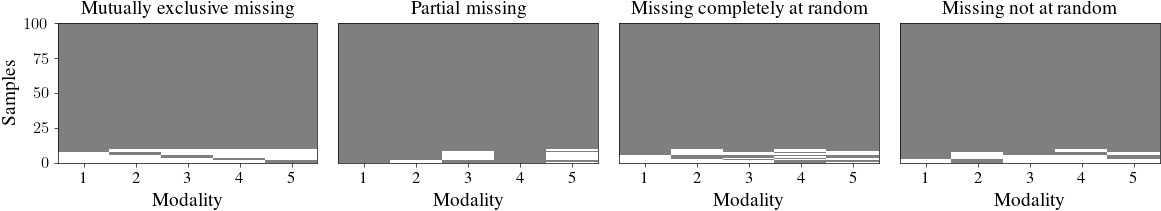

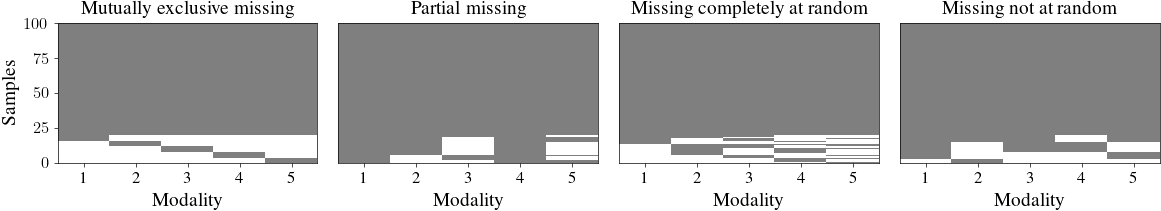

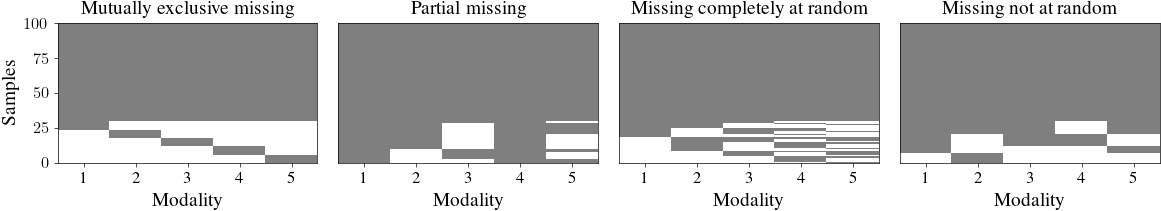

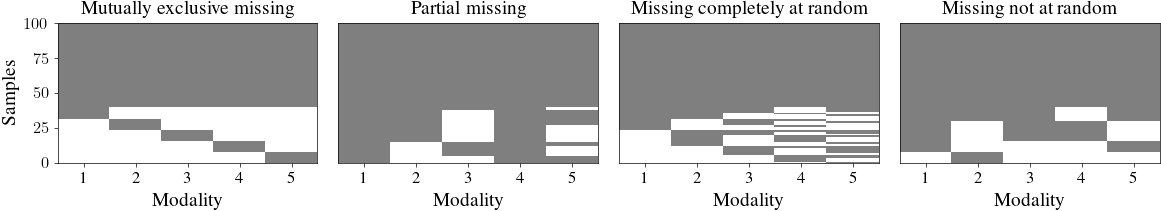

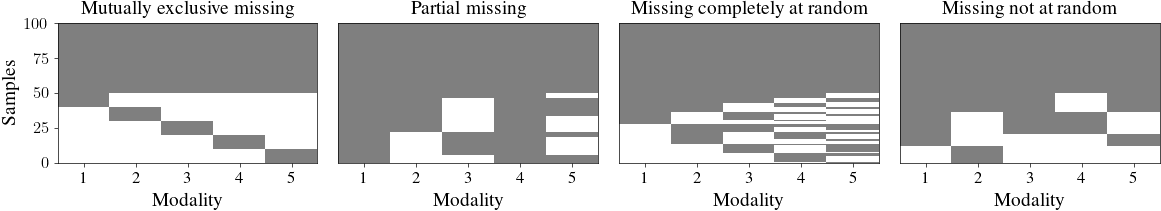

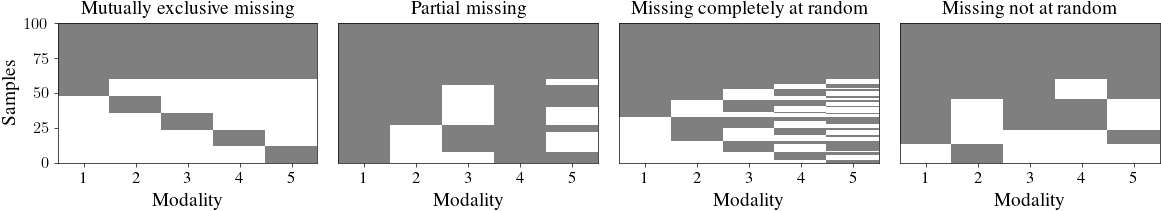

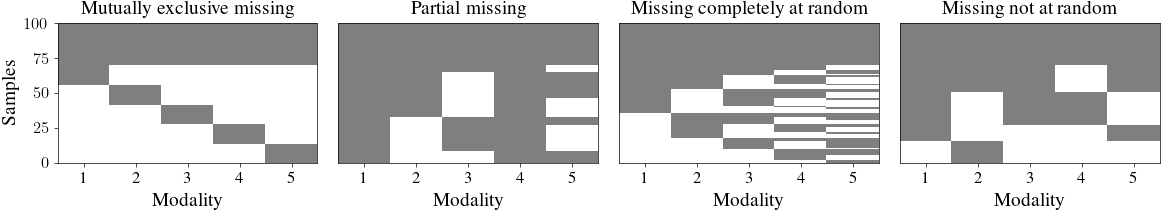

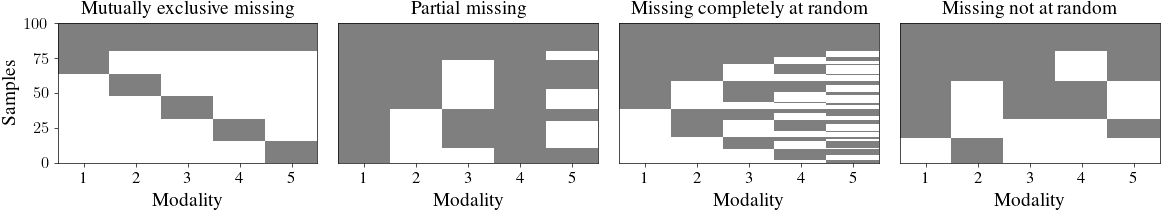

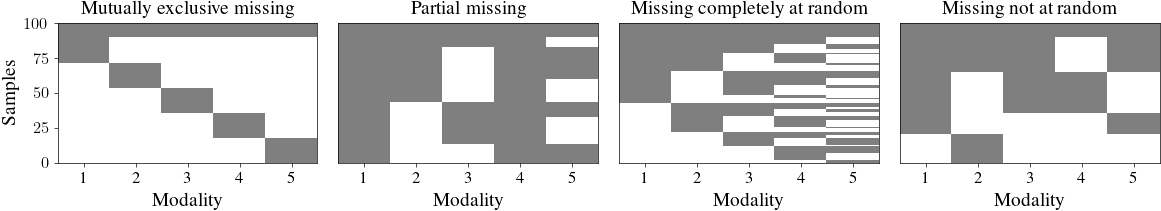

In [12]:
n_views = 5
n_samples = 100
Xs = [pd.DataFrame(np.random.default_rng(RANDOM_STATE).random((n_samples, 10))) for i in range(n_views)]
for p in np.arange(0.1, 1., 0.1):
    samples_dict = {}
    fig,axs = plt.subplots(1,4, figsize= (12,2.5))
    for idx, (ax, mechanism) in enumerate(zip(axs, list(mechanism_dict.keys()))):
        transformed_Xs = Amputer(mechanism=mechanism, p=p, random_state=RANDOM_STATE+1).fit_transform(Xs)
        observed_view_indicator = get_observed_mod_indicator(transformed_Xs).sort_values(list(range(len(transformed_Xs))))
        observed_view_indicator.columns = observed_view_indicator.columns + 1
        ax.pcolor(observed_view_indicator, cmap="binary", vmin=0., vmax=2.)
        ax.set_title(mechanism_dict[mechanism])
        ax.set_xticks(np.arange(0.5, len(observed_view_indicator.columns), 1), observed_view_indicator.columns)
        ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
        if idx != 0:
            ax.get_yaxis().set_visible(False)
        samples_dict[mechanism] = DatasetUtils.get_summary(Xs=transformed_Xs)
    plt.tight_layout()

    display(pd.DataFrame.from_dict(samples_dict, orient= "index"))